In [1]:
import scanpy as sc
import numpy as np
import seaborn as sea
import os
import matplotlib.pyplot as plt


filepath = "GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv"
adata = (sc.read_csv(filepath)).T



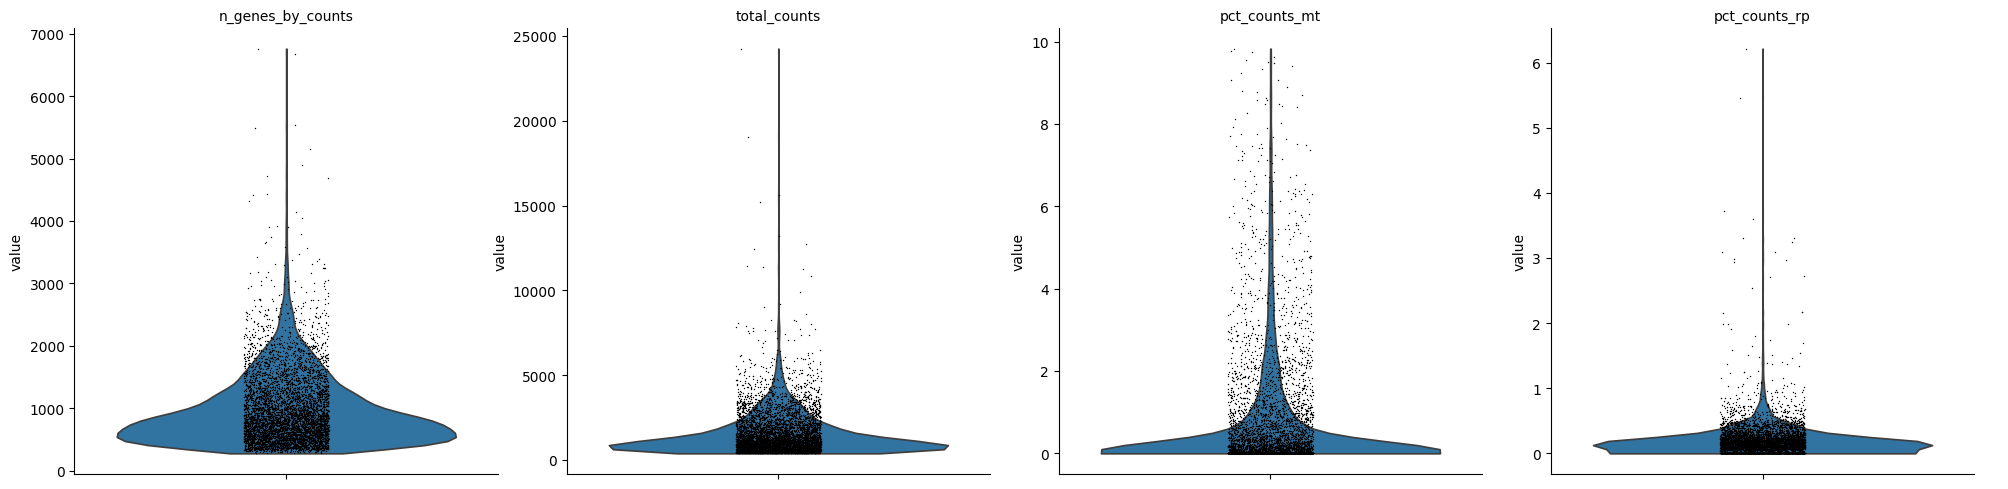

In [2]:
adata.var['mt'] = adata.var.index.str.startswith("MT-")
adata.var['rp'] = adata.var.index.str.startswith("RPL")+adata.var.index.str.startswith("RPS")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rp'], log1p=False, inplace=True)
sc.pl.violin(adata, keys=['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rp'],multi_panel=True)

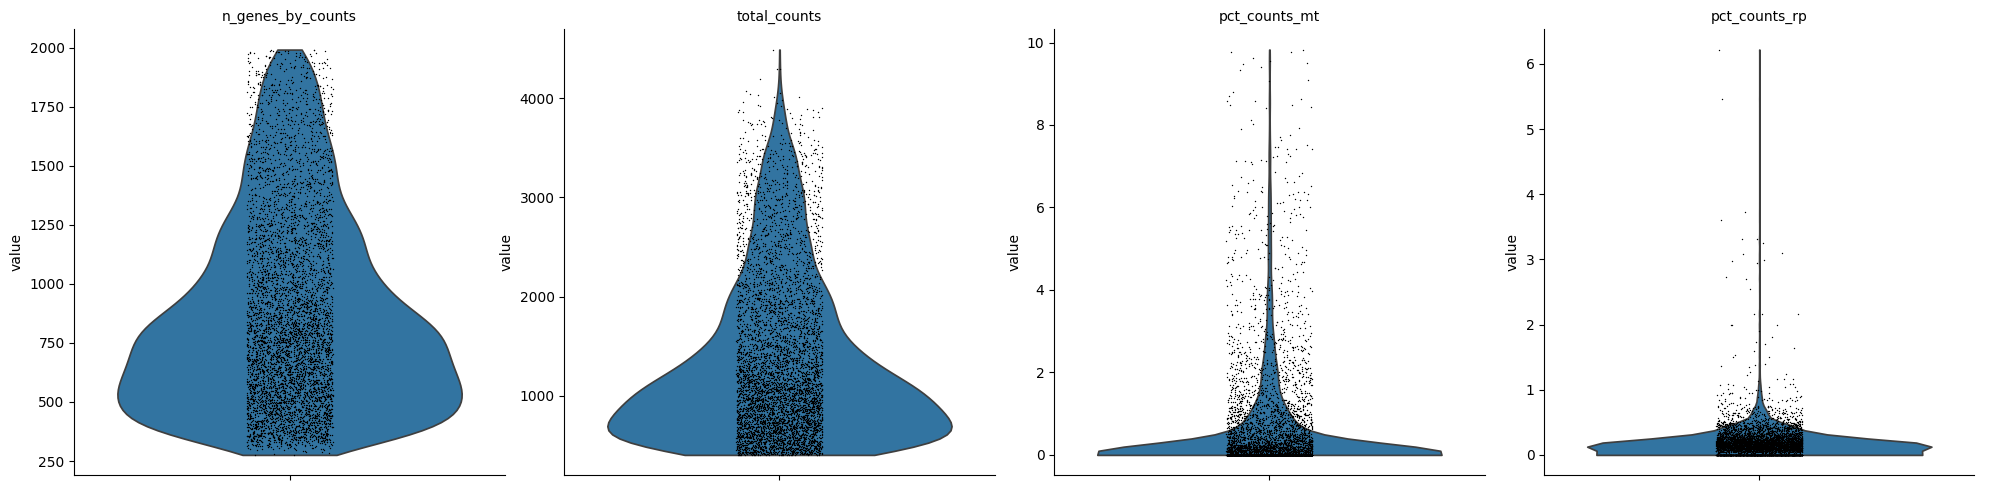

In [3]:
med_genes = np.median(adata.obs.n_genes_by_counts.values)
med_error = np.median( abs(med_genes-adata.obs.n_genes_by_counts.values) )
upper_thresh = med_genes+4*med_error
lower_thresh = med_genes-2*med_error

sc.pp.filter_cells(adata, min_genes=lower_thresh, inplace=True)
sc.pp.filter_cells(adata, max_genes=upper_thresh, inplace=True)
sc.pl.violin(adata, keys=['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rp'],multi_panel=True)

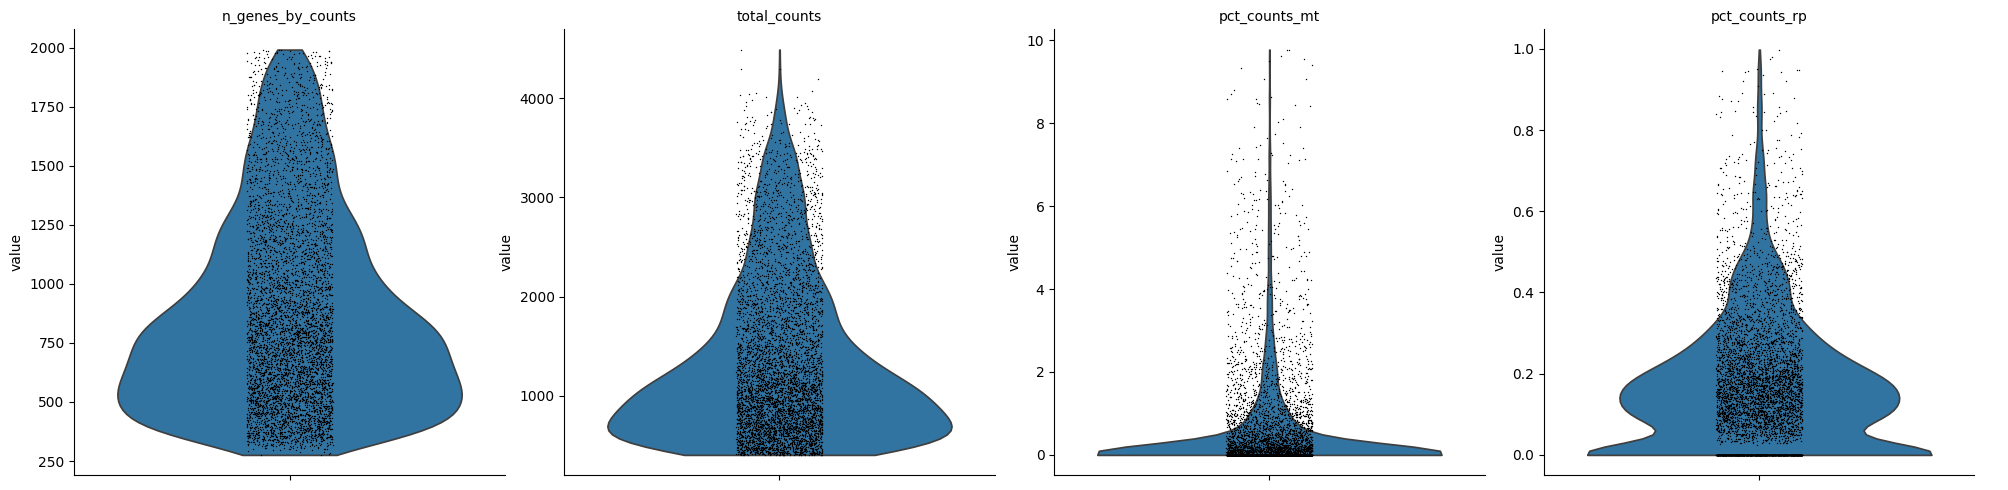

In [4]:
adata = adata[adata.obs['pct_counts_rp']<1]
sc.pl.violin(adata, keys=['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rp'],multi_panel=True)

Trying to set attribute `.var` of view, copying.


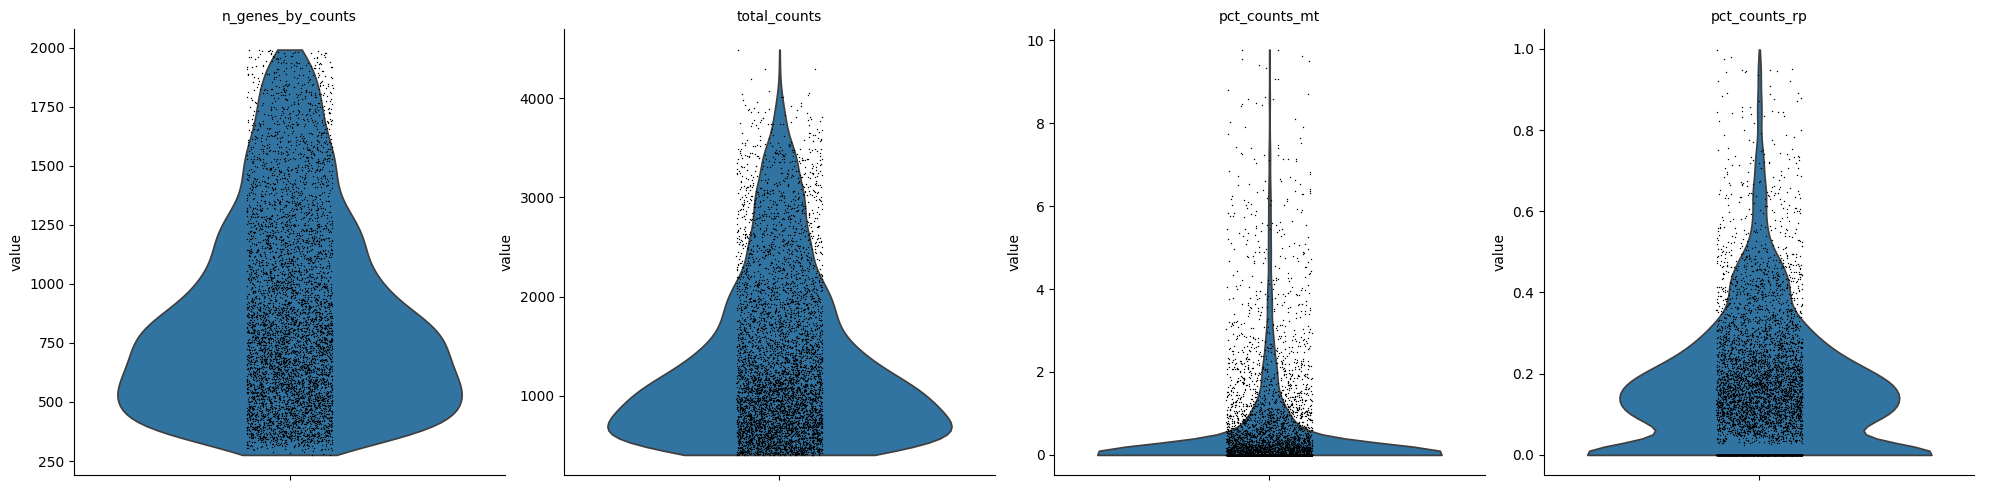

In [5]:
sc.pp.filter_genes(adata, min_cells=10,inplace=True)
sc.pl.violin(adata, keys=['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rp'],multi_panel=True)

In [6]:
adata.raw = adata

sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata,base=10)
sc.pp.regress_out(adata,keys=['pct_counts_mt', 'pct_counts_rp'],n_jobs=3)

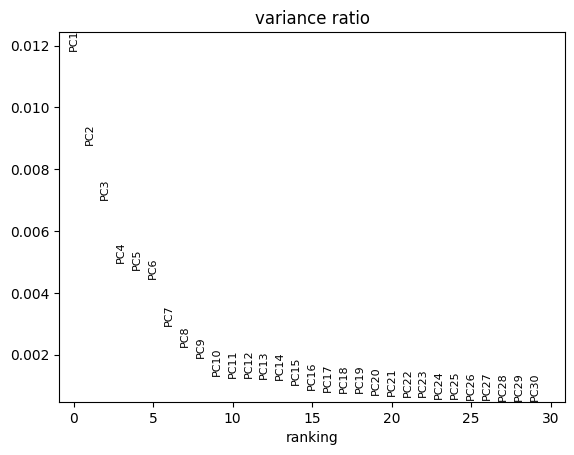

In [7]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=30, svd_solver='auto')
sc.pl.pca_variance_ratio(adata)

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


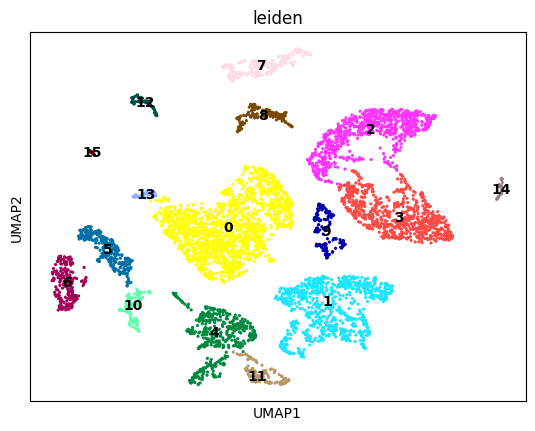

In [18]:
sc.pp.neighbors(adata,n_pcs=20,n_neighbors=5)
sc.tl.umap(adata, n_components=2)
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

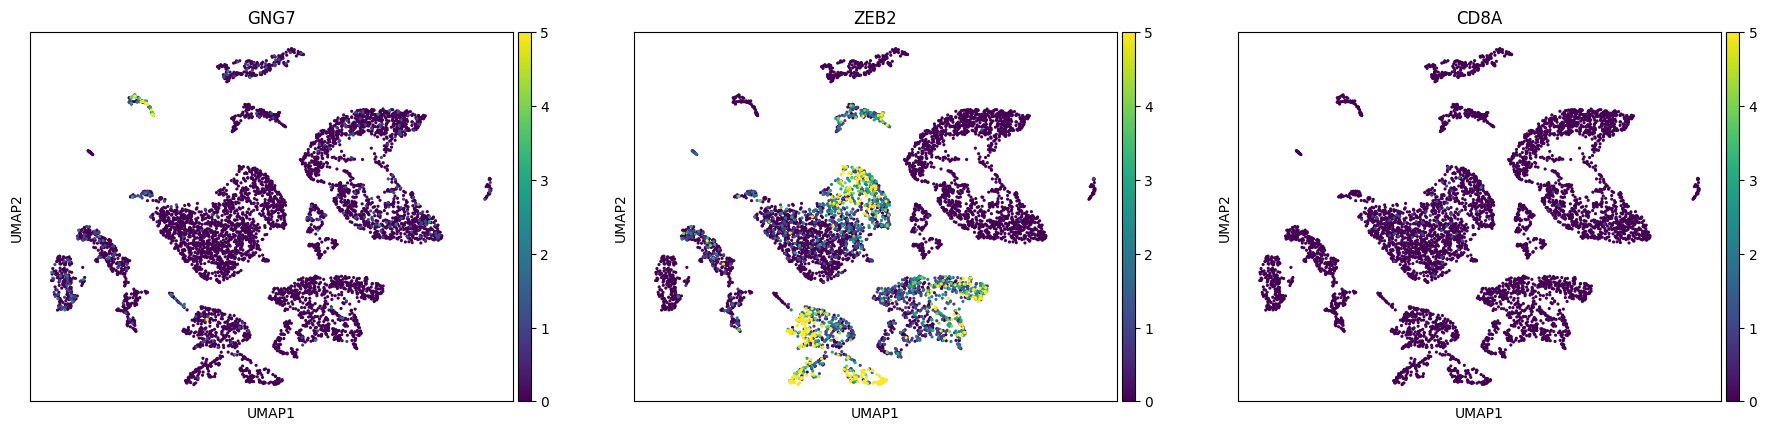

In [109]:
sc.pl.umap(adata, color=['GNG7','ZEB2', 'CD8A'], legend_loc='on data',vmax=5)

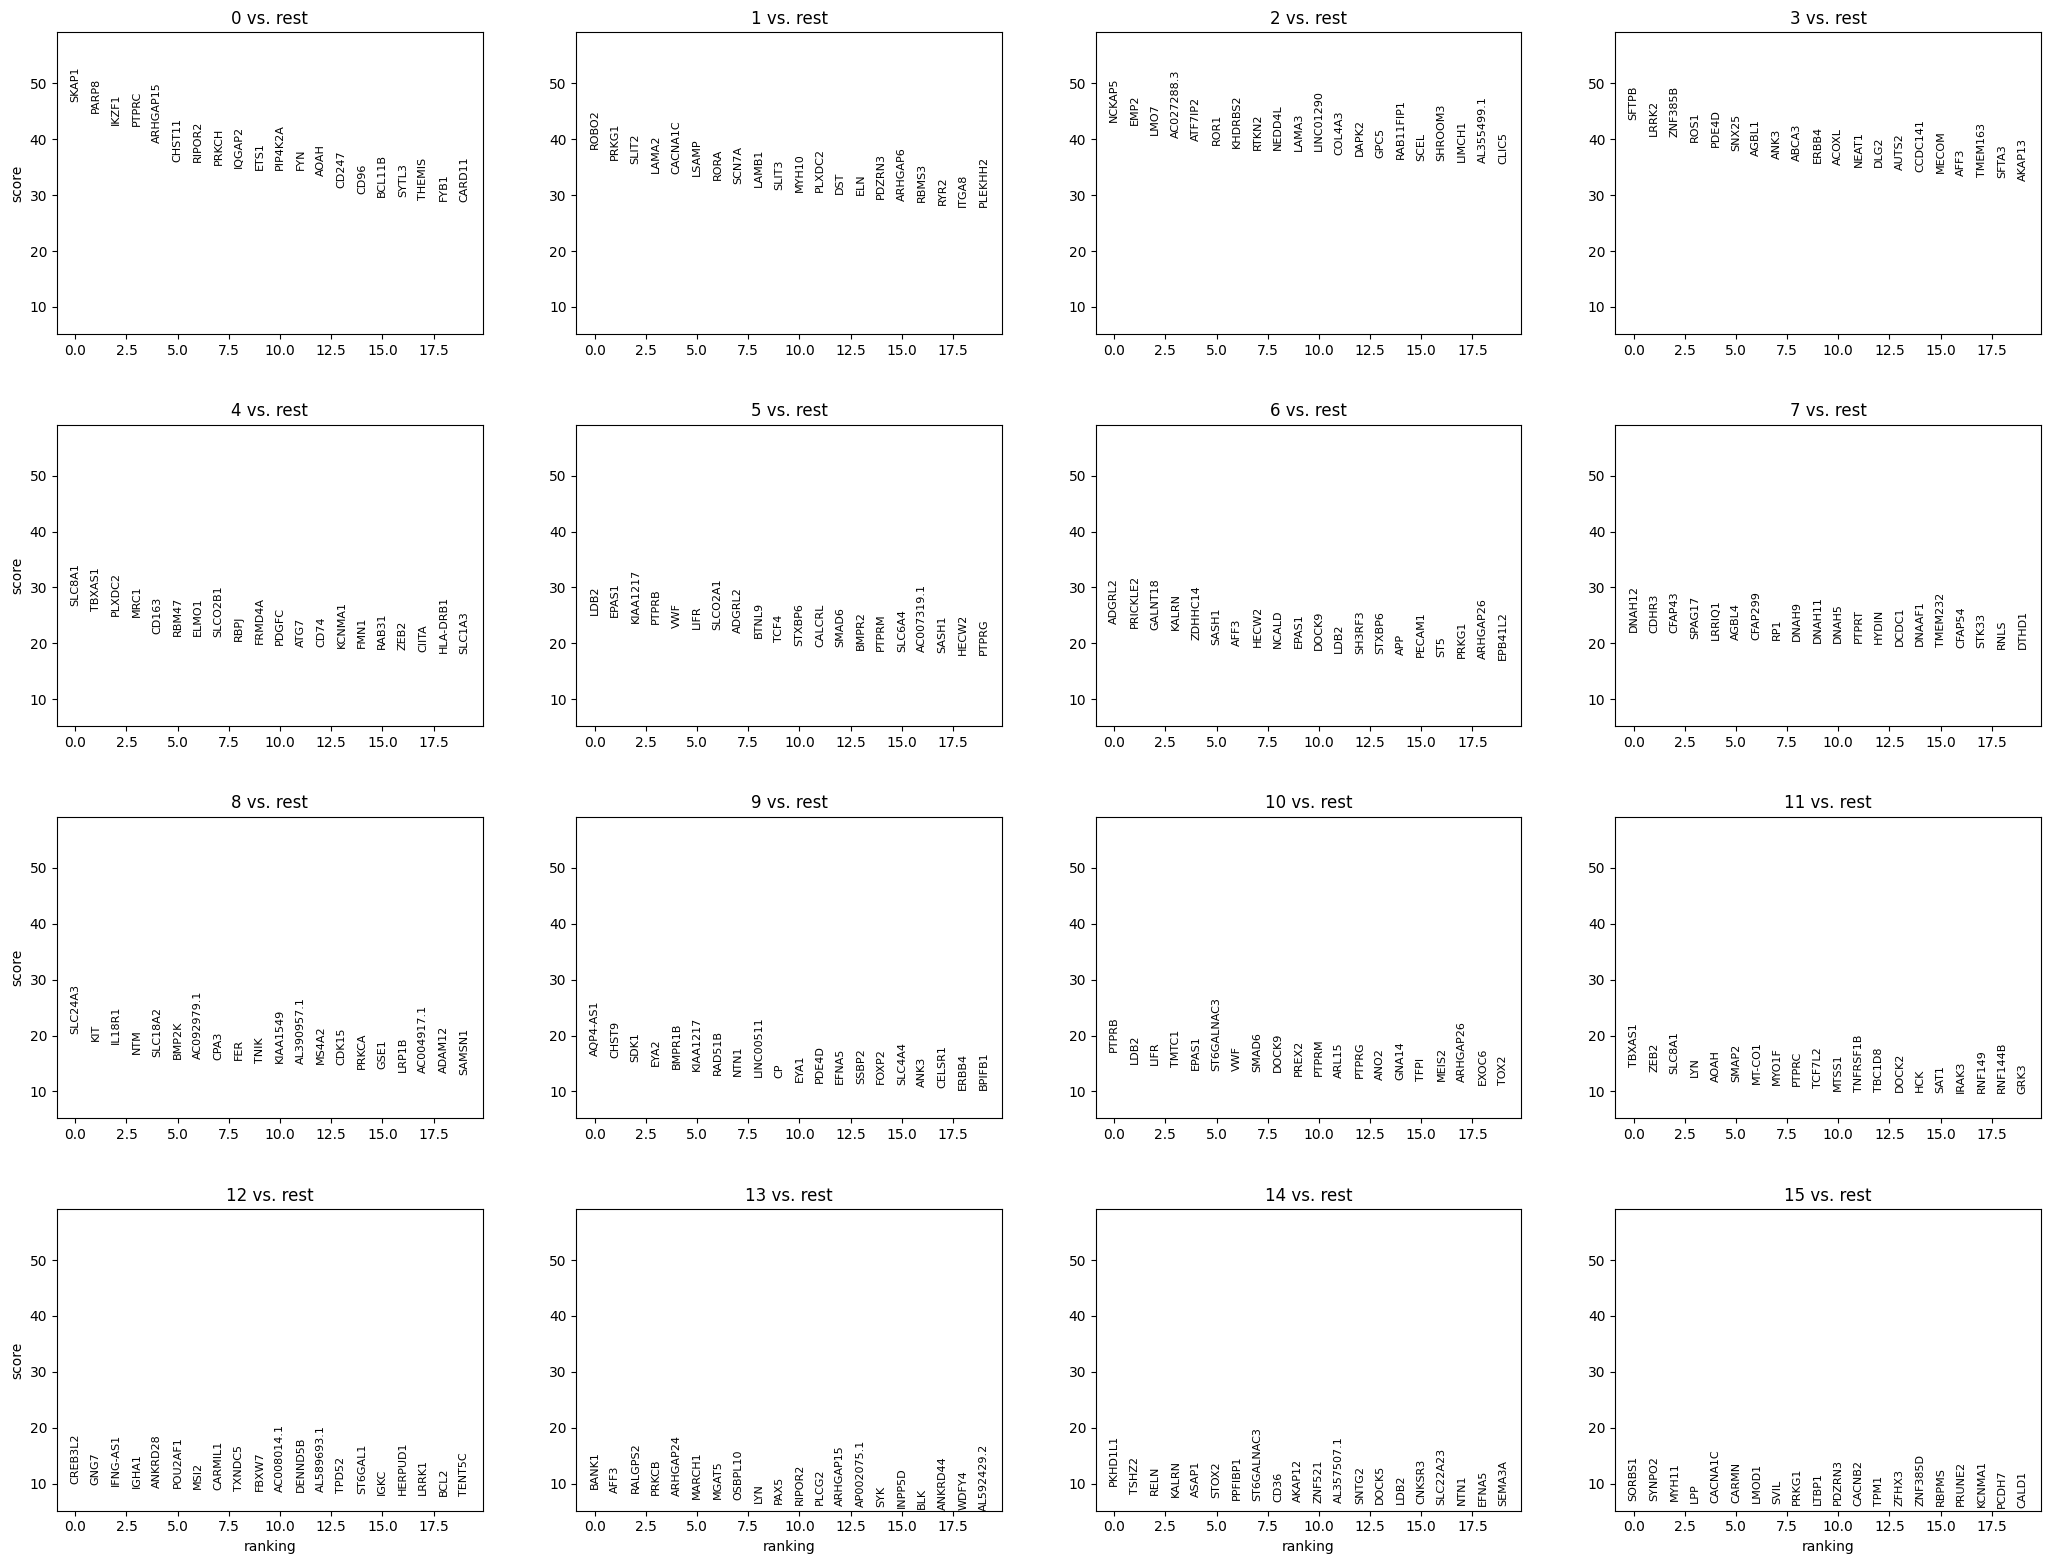

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', n_genes=20, use_raw=True, method='wilcoxon')
sc.pl.rank_genes_groups(adata)

In [25]:
markers = sc.get.rank_genes_groups_df(adata,None)
markers = markers[(markers.pvals_adj<0.01)*(markers.logfoldchanges>1.0)]
#markers[markers.group=='15']
map_dict = {'0':'T-cells',  '1':'Neuron',    '2':'Alve_1',  '3':'Alve_2',  '4':'Macro_i',\
 '5':'Endoth_i', '6':'Endoth_ii', '7':'Cilia' ,  '8':'Granul',  '9':'Club',\
 '10':'Epithel', '11':'Macro_ii', '12':'Plasma', '13':'B-cells','14':'Endoth_iii',\
 '15': 'Ambig'}

/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


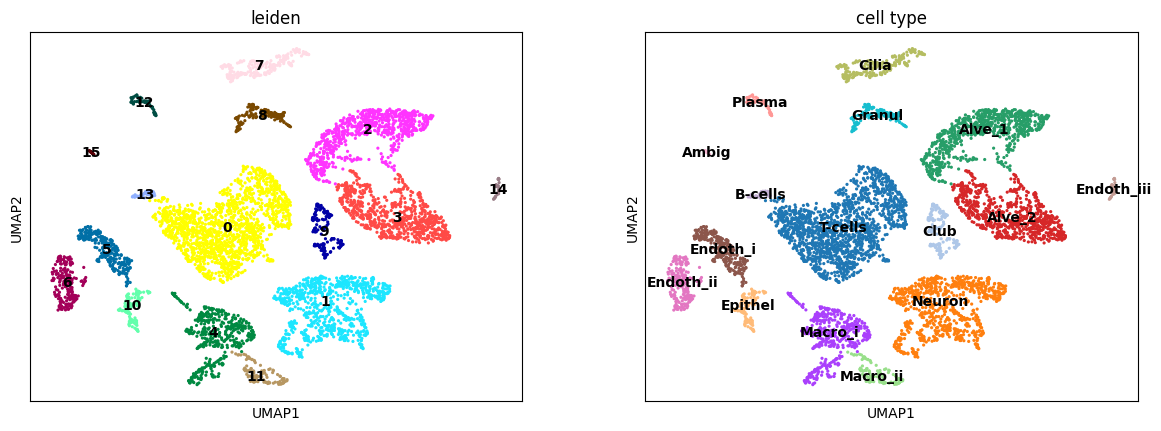

In [26]:
adata.obs['cell type'] = adata.obs.leiden.map(map_dict)
sc.pl.umap(adata, color=['leiden', 'cell type'], legend_loc='on data')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'T-cells'),
  Text(1, 0, 'Neuron'),
  Text(2, 0, 'Alve_1'),
  Text(3, 0, 'Alve_2'),
  Text(4, 0, 'Macro_i'),
  Text(5, 0, 'Endoth_i'),
  Text(6, 0, 'Endoth_ii'),
  Text(7, 0, 'Cilia'),
  Text(8, 0, 'Granul'),
  Text(9, 0, 'Club'),
  Text(10, 0, 'Epithel'),
  Text(11, 0, 'Macro_ii'),
  Text(12, 0, 'Plasma'),
  Text(13, 0, 'B-cells'),
  Text(14, 0, 'Endoth_iii'),
  Text(15, 0, 'Ambig')])

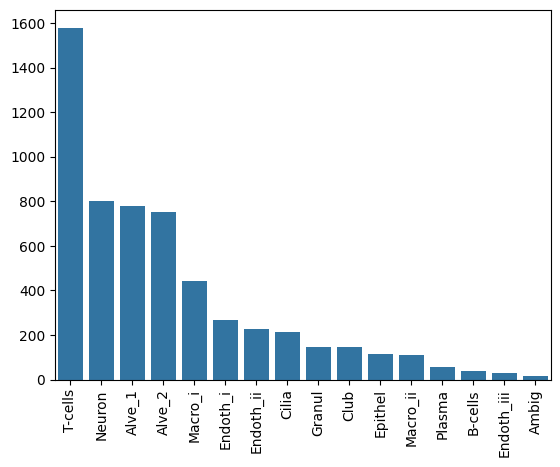

In [27]:
x_labels = ['T-cells', 'Neuron', 'Alve_1', 'Alve_2','Macro_i','Endoth_i','Endoth_ii', \
            'Cilia' ,'Granul','Club','Epithel','Macro_ii','Plasma','B-cells','Endoth_iii','Ambig']
counts = adata.obs.groupby(['cell type']).count()
y_data = counts.n_genes_by_counts.values
sea.barplot(x=x_labels,y=y_data)
plt.xticks(rotation=90)


Trying to set attribute `._uns` of view, copying.


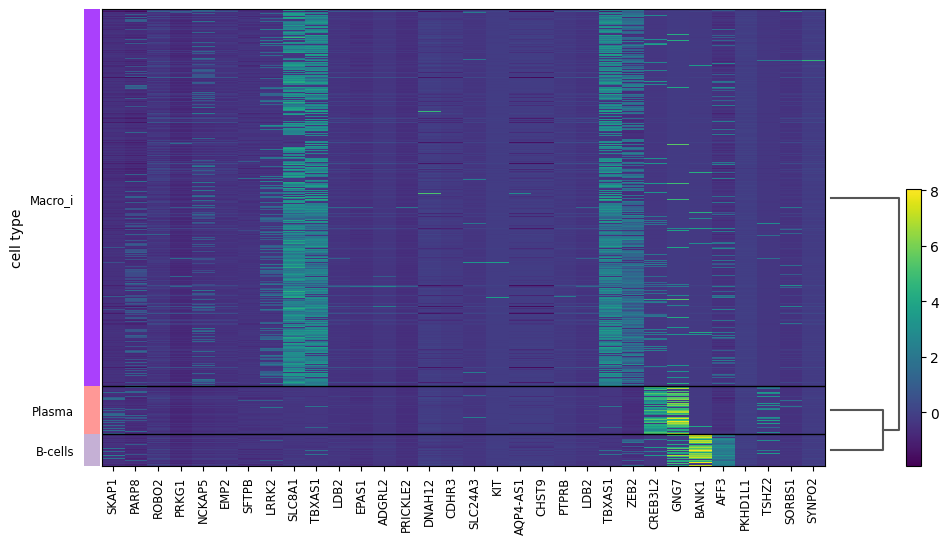

In [102]:
genes_int = markers.names[(markers.names.index.values%20==0) + (markers.names.index.values%20==1)]
#genes_int = markers.names[(markers.group=='4') + (markers.group=='12') + (markers.group=='13')]
subset = adata[(adata.obs['cell type']=='Macro_i') + (adata.obs['cell type']=='Plasma')+\
               (adata.obs['cell type']=='B-cells')]
sc.pl.heatmap(subset, genes_int, 'cell type', use_raw=False, dendrogram=True)

In [70]:
markers
sum(markers.group=='5')

20

,group,names,scores,logfoldchanges,pvals,pvals_adj


In [ ]:
def pp(filepath):
    adata = (sc.read_csv(filepath)).T
    adata.var['mt'] = adata.var.index.str.startswith("MT-")
    adata.var['rp'] = adata.var.index.str.startswith("RPL")+adata.var.index.str.startswith("RPS")
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rp'], log1p=False, inplace=True)
   
    med_genes = np.median(adata.obs.n_genes_by_counts.values)
    med_error = np.median( abs(med_genes-adata.obs.n_genes_by_counts.values) )
    upper_thresh = med_genes+4*med_error
    lower_thresh = med_genes-2*med_error
    sc.pp.filter_cells(adata, min_genes=lower_thresh, inplace=True)
    sc.pp.filter_cells(adata, max_genes=upper_thresh, inplace=True)
    
    adata = adata[adata.obs['pct_counts_rp']<1]
    
    sc.pp.filter_genes(adata, min_cells=10,inplace=True)
    
    adata.obs['Sample'] = filepath.split('_')[2]
    print(adata.obs)
    
    return adata

all_data=[]
counter=0
for filename in os.listdir('GSE171524_RAW/'):
    if filename=='.DS_Store':
        continue
    filepath = 'GSE171524_RAW/'+filename
    all_data.append( pp(filepath) )
    counter += 1
    if counter==4:
        break

total_data = sc.concat(all_data)
sc.pp.normalize_total(total_data, target_sum=1e4, inplace=True)
sc.pp.log1p(total_data,base=10)
sc.pp.regress_out(total_data,keys=['pct_counts_mt', 'pct_counts_rp'],n_jobs=3)